In [166]:
import os
import numpy as np
import subprocess
from collections import defaultdict
from pathlib import Path
from biotite.sequence import ProteinSequence
from biotite.sequence import find_subsequence
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import biotite.structure.info as info


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plot_plane_projection import plot_atoms_near_plane, make_shared_norms

base_dir = "/workspaces/tcr_structure_embedding/killing_assay/tcrmodel2_out"

tra_id = "D"
trb_id = "E"
pep_id = "C"
mhca_id = "A"

In [167]:
def get_subsequence_indices(model, chainid, subsequence):
    chainid = np.where(struc.get_chains(model) == chainid)[0][0]

    seqs, seq_starts = struc.to_sequence(model)
    sequence = seqs[chainid]
    chain_start = seq_starts[chainid]
    res_starts = struc.get_residue_starts(model, add_exclusive_stop=True)
    res_starts = res_starts[res_starts>=chain_start]
    
    sub_start = find_subsequence(sequence, subsequence)
    
    if len(sub_start)>1:
        raise ValueError("Multiple subsequence detected.")
    
    sub_start = sub_start[0]
    sub_end = sub_start + len(subsequence)
    
    return res_starts[sub_start], res_starts[sub_end]

def get_cdr_sequence(sequence):
    command = ["bash", "/workspaces/tcr_structure_embedding/structure_feature/sequence/alignment/run_anarci.sh", 
            "-i", str(sequence), 
            "-s", "a"]
    command.append("--assign_germline")
    result = subprocess.run(command, capture_output=True, text=True, check=True)

    lines = result.stdout.strip().split("#")
    alignment = lines[-1]
    alignment = alignment.strip().split("\n")[1:]
    alignment = [a.strip().split() for a in alignment if a.strip() != '//']
    if len(alignment) == 0:
        return None
    
    chain_type = np.unique([a[0] for a in alignment if (len(a)==3)])
    if len(chain_type) != 1:
        raise TypeError(f"{len(chain_type)} chains detected")
    
    cdr1 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 25) and (int(a[1]) <= 42) and (a[2].isalpha())]
    cdr2 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 58) and (int(a[1]) <= 77) and (a[2].isalpha())]
    cdr3 = [a[2] for a in alignment if (len(a)==3) and (int(a[1]) >= 107) and (int(a[1]) <= 138) and (a[2].isalpha())]
    return chain_type[0], ''.join(cdr1), ''.join(cdr2), ''.join(cdr3)


In [168]:
BACKBONE = ['N', 'CA', 'C', 'O']
tcr_proj = dict()

In [ ]:
for tcr in os.listdir(base_dir):
    if tcr.startswith("tcr"):
        if tcr in tcr_proj:
            continue
        pdb_path = Path(base_dir, tcr, "ranked_0_proj.pdb")
        pdb_file = pdb.PDBFile.read(pdb_path)
        pdb1 = pdb_file.get_structure()
        if len(pdb1) > 1:
            raise ValueError(f"{pdb_path} has more than 1 model.")
        obj = pdb1[0]
        out = dict()
        
        chain_ids = struc.get_chains(obj)
        seq, _ = struc.to_sequence(obj)
        sequences = {c:s for c, s in zip(chain_ids, seq)}
        out['chainid_to_seq'] = sequences
        out['chain_id'] = dict()
    
        for chainid, seq in sequences.items():
            aligned = get_cdr_sequence(str(seq))
            if aligned is not None:
                chaintype, cdr1, cdr2, cdr3 = aligned
                if chaintype == 'A':
                    out['chain_id']['tra'] = chainid
                    out['cdr_a'] = {'cdr1':ProteinSequence(cdr1), 'cdr2':ProteinSequence(cdr2), 'cdr3':ProteinSequence(cdr3)}
                if chaintype == 'B':
                    out['chain_id']['trb'] = chainid
                    out['cdr_b'] = {'cdr1':ProteinSequence(cdr1), 'cdr2':ProteinSequence(cdr2), 'cdr3':ProteinSequence(cdr3)}
            else:
                if len(seq) > 50:
                    out['chain_id']['mhca'] = chainid
                    sse = struc.annotate_sse(obj[obj.chain_id == chainid])
                    arr = np.where(sse=='a')[0]
                    # Find index of largest gap
                    idx_split = np.argmax(np.diff(arr))
                    out['mhc'] = dict()
                    out['mhc']['helix1'] = seq[arr[0]:arr[idx_split]+1]
                    out['mhc']['helix2'] = seq[arr[idx_split+1]:arr[-1]+1]
                else:
                    out['chain_id']['pep'] = chainid
        
        tcr_proj[tcr] = dict()
        tcr_proj[tcr]['model'] = obj
        tcr_proj[tcr]['info'] = out
        
import pickle

with open(Path(base_dir, "tcr_projection.pt"), "wb") as f:
    pickle.dump(tcr_proj,f)


In [74]:
def get_coordinates(tcrplane):
    obj = tcrplane['model']
    out = tcrplane['info']
    target = {}
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['tra'], out['cdr_a'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}α"] = sam[~np.isin(sam.atom_name, BACKBONE)]
        
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['trb'], out['cdr_b'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}β"] = sam[~np.isin(sam.atom_name, BACKBONE)]
        
    target["TRA"] = obj[(obj.chain_id == out['chain_id']['tra'])]
    target["TRB"] = obj[(obj.chain_id == out['chain_id']['trb'])]

    target["Peptide"] = obj[(obj.chain_id == out['chain_id']['pep']) & (obj.atom_name == 'CA')]

    start, end = get_subsequence_indices(obj, out['chain_id']['mhca'], out['mhc']['helix1'])
    sam = obj[start:end]
    target["MHC helix1"] = sam[(sam.chain_id==out['chain_id']['mhca']) & (sam.atom_name == 'CA')]

    start, end = get_subsequence_indices(obj, out['chain_id']['mhca'], out['mhc']['helix2'])
    sam = obj[start:end]
    target["MHC helix2"] = sam[(sam.chain_id==out['chain_id']['mhca']) & (sam.atom_name == 'CA')]
            
    return target


In [75]:
for k, v in tcr_proj.items():
    tcr_proj[k]['proj_coords'] = get_coordinates(v)

In [79]:
# ---------- Aggregate ranked_0 only ----------
def aggregate_positions(group_dict):
    """
    group_dict: dict[tcr_name -> dict[model_idx -> target_dict]]
    returns: dict[chain_key -> (N,3) ndarray]
    """
    buckets = defaultdict(list)  # chain_key -> list of (M,3) arrays

    for tcr_name, target in group_dict.items():
        # if "0" not in models:
        #     continue
        # target = models["0"]

        for key, val in target.items():
            # val can be an AtomGroup or an ndarray
            if hasattr(val, "coord"):          # AtomGroup (CDRs)
                arr = np.asarray(val.coord, float)
            else:                                   # ndarray already (TRA/TRB/Peptide/Helices)
                arr = np.asarray(val, float)

            # ensure (N,3)
            if arr.size == 0:
                continue
            arr = arr.reshape(-1, 3)
            buckets[key].append(arr)

    # stack each key
    aggregated = {}
    for key, arrays in buckets.items():
        if arrays:
            aggregated[key] = np.vstack(arrays)
    return aggregated

In [104]:
b3501_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr363', 'tcr374', 'tcr462']})
b3501_no = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr14', 'tcr420', 'tcr520']})

b4001_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr177','tcr181']})
b4001_no = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr417']})

a0201_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr100','tcr102','tcr107','tcr43','tcr76','tcr475','tcr173']})
a2402_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr371','tcr425','tcr450','tcr452']})

b2705_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr149','tcr159']})
b3901_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr7','tcr168','tcr212','tcr296']})

c0702_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr214']})
c1203_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr20']})

/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_4086/4066564369.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


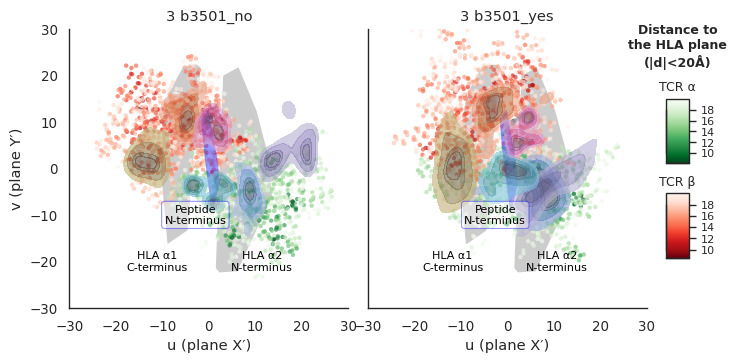

In [105]:
lims = ((-30, 30), (-30, 30))
threshold = 20

shared_norms = make_shared_norms(
    [b3501_yes, b3501_no],          # put the two dicts you’re comparing here
    z_thresh=threshold,
    color_by="signed"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.48, 0.48, 0.04], "wspace": 0.1, "hspace": 0.0})

# Redraw each onto the new axes
fig1, ax1, maps1 = plot_atoms_near_plane(
    b3501_no,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="3 b3501_no",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(6,4),
    fixed_limits=lims,
    ax=axes[0]
)

fig2, ax2, maps2 = plot_atoms_near_plane(
    b3501_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="3 b3501_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(8,4),
    fixed_limits=lims,
    ax=axes[1]
)

# --- Right panel (colorbars only)
ax_cb = axes[2]
ax_cb.axis("off")  # no data plotted here

divider = make_axes_locatable(ax_cb)

# a small title axes at the very top
cax2 = divider.append_axes("top", size="100%", pad=0.0)
cax1 = divider.append_axes("top", size="100%", pad=0.3)

# Retrieve TRA and TRB mappables from fig2 (killing complexes)
sm_tra = maps2.get("TRA")
sm_trb = maps2.get("TRB")

if sm_trb:
    cbar2 = fig.colorbar(sm_trb, cax=cax2, orientation="vertical")
    cbar2.ax.set_title("TCR β", fontsize=9)
    cbar2.ax.tick_params(labelsize=8)

if sm_tra:
    cbar1 = fig.colorbar(sm_tra, cax=cax1, orientation="vertical")
    cbar1.ax.set_title("TCR α", fontsize=9)
    cbar1.ax.tick_params(labelsize=8)

ax_title = divider.append_axes("top", size="100%", pad=0.2)
ax_title.set_axis_off()
ax_title.text(0.5, 0.5, f"Distance to\nthe HLA plane\n(|d|<{threshold:g}Å)",
              ha="center", va="center", fontsize=9, fontweight="bold")


for a in axes[:2]:
    a.label_outer()
sns.despine(fig=fig, trim=True)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.show()

# pdf_path = os.path.join(base_dir, "side_by_side_with_colorbar_column.pdf")
# fig.savefig(pdf_path, dpi=1000, bbox_inches="tight")
# print(f"[ok] Saved: {pdf_path}")


/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_4086/3808655656.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


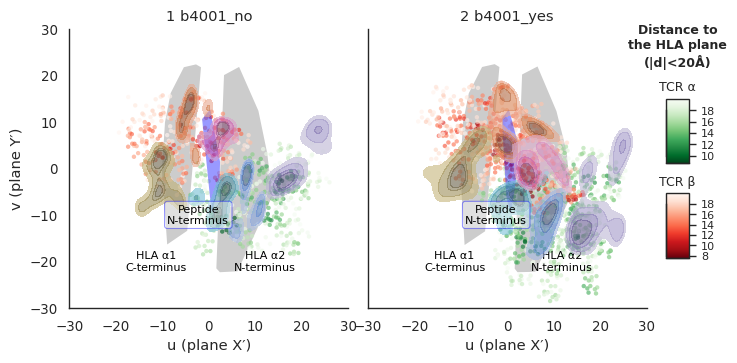

In [106]:
lims = ((-30, 30), (-30, 30))
threshold = 20

shared_norms = make_shared_norms(
    [b4001_no, b4001_yes],          # put the two dicts you’re comparing here
    z_thresh=threshold,
    color_by="signed"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.48, 0.48, 0.04], "wspace": 0.1, "hspace": 0.0})

# Redraw each onto the new axes
fig1, ax1, maps1 = plot_atoms_near_plane(
    b4001_no,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="1 b4001_no",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(6,4),
    fixed_limits=lims,
    ax=axes[0]
)

fig2, ax2, maps2 = plot_atoms_near_plane(
    b4001_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="2 b4001_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(8,4),
    fixed_limits=lims,
    ax=axes[1]
)

# --- Right panel (colorbars only)
ax_cb = axes[2]
ax_cb.axis("off")  # no data plotted here

divider = make_axes_locatable(ax_cb)

# a small title axes at the very top
cax2 = divider.append_axes("top", size="100%", pad=0.0)
cax1 = divider.append_axes("top", size="100%", pad=0.3)

# Retrieve TRA and TRB mappables from fig2 (killing complexes)
sm_tra = maps2.get("TRA")
sm_trb = maps2.get("TRB")

if sm_trb:
    cbar2 = fig.colorbar(sm_trb, cax=cax2, orientation="vertical")
    cbar2.ax.set_title("TCR β", fontsize=9)
    cbar2.ax.tick_params(labelsize=8)

if sm_tra:
    cbar1 = fig.colorbar(sm_tra, cax=cax1, orientation="vertical")
    cbar1.ax.set_title("TCR α", fontsize=9)
    cbar1.ax.tick_params(labelsize=8)

ax_title = divider.append_axes("top", size="100%", pad=0.2)
ax_title.set_axis_off()
ax_title.text(0.5, 0.5, f"Distance to\nthe HLA plane\n(|d|<{threshold:g}Å)",
              ha="center", va="center", fontsize=9, fontweight="bold")


for a in axes[:2]:
    a.label_outer()
sns.despine(fig=fig, trim=True)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.show()

# pdf_path = os.path.join(base_dir, "side_by_side_with_colorbar_column.pdf")
# fig.savefig(pdf_path, dpi=1000, bbox_inches="tight")
# print(f"[ok] Saved: {pdf_path}")


/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_4086/3837655172.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


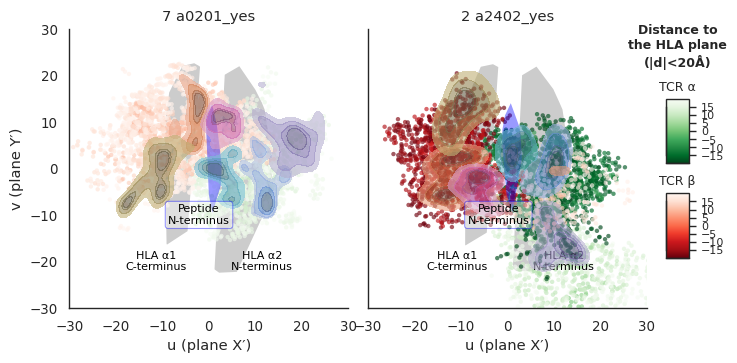

In [107]:
lims = ((-30, 30), (-30, 30))
threshold = 20

shared_norms = make_shared_norms(
    [a0201_yes, a2402_yes],          # put the two dicts you’re comparing here
    z_thresh=threshold,
    color_by="signed"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.48, 0.48, 0.04], "wspace": 0.1, "hspace": 0.0})

# Redraw each onto the new axes
fig1, ax1, maps1 = plot_atoms_near_plane(
    a0201_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="7 a0201_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(6,4),
    fixed_limits=lims,
    ax=axes[0]
)

fig2, ax2, maps2 = plot_atoms_near_plane(
    a2402_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="2 a2402_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(8,4),
    fixed_limits=lims,
    ax=axes[1]
)

# --- Right panel (colorbars only)
ax_cb = axes[2]
ax_cb.axis("off")  # no data plotted here

divider = make_axes_locatable(ax_cb)

# a small title axes at the very top
cax2 = divider.append_axes("top", size="100%", pad=0.0)
cax1 = divider.append_axes("top", size="100%", pad=0.3)

# Retrieve TRA and TRB mappables from fig2 (killing complexes)
sm_tra = maps2.get("TRA")
sm_trb = maps2.get("TRB")

if sm_trb:
    cbar2 = fig.colorbar(sm_trb, cax=cax2, orientation="vertical")
    cbar2.ax.set_title("TCR β", fontsize=9)
    cbar2.ax.tick_params(labelsize=8)

if sm_tra:
    cbar1 = fig.colorbar(sm_tra, cax=cax1, orientation="vertical")
    cbar1.ax.set_title("TCR α", fontsize=9)
    cbar1.ax.tick_params(labelsize=8)

ax_title = divider.append_axes("top", size="100%", pad=0.2)
ax_title.set_axis_off()
ax_title.text(0.5, 0.5, f"Distance to\nthe HLA plane\n(|d|<{threshold:g}Å)",
              ha="center", va="center", fontsize=9, fontweight="bold")


for a in axes[:2]:
    a.label_outer()
sns.despine(fig=fig, trim=True)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.show()

# pdf_path = os.path.join(base_dir, "side_by_side_with_colorbar_column.pdf")
# fig.savefig(pdf_path, dpi=1000, bbox_inches="tight")
# print(f"[ok] Saved: {pdf_path}")


/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_4086/688388044.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


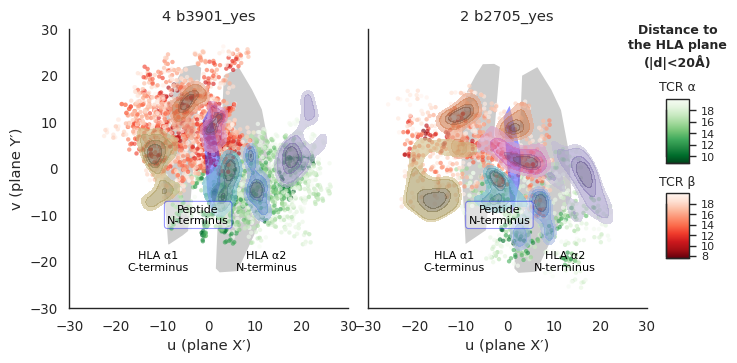

In [108]:
lims = ((-30, 30), (-30, 30))
threshold = 20

shared_norms = make_shared_norms(
    [b3901_yes, b2705_yes],          # put the two dicts you’re comparing here
    z_thresh=threshold,
    color_by="signed"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.48, 0.48, 0.04], "wspace": 0.1, "hspace": 0.0})

# Redraw each onto the new axes
fig1, ax1, maps1 = plot_atoms_near_plane(
    b3901_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="4 b3901_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(6,4),
    fixed_limits=lims,
    ax=axes[0]
)

fig2, ax2, maps2 = plot_atoms_near_plane(
    b2705_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="2 b2705_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(8,4),
    fixed_limits=lims,
    ax=axes[1]
)

# --- Right panel (colorbars only)
ax_cb = axes[2]
ax_cb.axis("off")  # no data plotted here

divider = make_axes_locatable(ax_cb)

# a small title axes at the very top
cax2 = divider.append_axes("top", size="100%", pad=0.0)
cax1 = divider.append_axes("top", size="100%", pad=0.3)

# Retrieve TRA and TRB mappables from fig2 (killing complexes)
sm_tra = maps2.get("TRA")
sm_trb = maps2.get("TRB")

if sm_trb:
    cbar2 = fig.colorbar(sm_trb, cax=cax2, orientation="vertical")
    cbar2.ax.set_title("TCR β", fontsize=9)
    cbar2.ax.tick_params(labelsize=8)

if sm_tra:
    cbar1 = fig.colorbar(sm_tra, cax=cax1, orientation="vertical")
    cbar1.ax.set_title("TCR α", fontsize=9)
    cbar1.ax.tick_params(labelsize=8)

ax_title = divider.append_axes("top", size="100%", pad=0.2)
ax_title.set_axis_off()
ax_title.text(0.5, 0.5, f"Distance to\nthe HLA plane\n(|d|<{threshold:g}Å)",
              ha="center", va="center", fontsize=9, fontweight="bold")


for a in axes[:2]:
    a.label_outer()
sns.despine(fig=fig, trim=True)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.show()

# pdf_path = os.path.join(base_dir, "side_by_side_with_colorbar_column.pdf")
# fig.savefig(pdf_path, dpi=1000, bbox_inches="tight")
# print(f"[ok] Saved: {pdf_path}")


In [ ]:
import os
import numpy as np
import biotite.structure.io.pdb as pdb
from structure.mhc_plane import mhc_plane
from biotite.sequence import ProteinSequence
import biotite.structure.info as info

ref_struc = pdb.PDBFile.read("/workspaces/tcr_structure_embedding/killing_assay/tcrmodel2_out/tcr14/ranked_0.pdb").get_structure()
ref_plane = mhc_plane(ref_struc[0])

ref_mhc= ref_struc[0][
    (ref_struc.chain_id == "A") &
    (np.isin(ref_struc.res_id, np.arange(1, 179+1)))
]


/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/workspaces/tcr_structure_embedding/structure_feature/plot_plane_projection.py:371: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_4086/409542171.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 1])


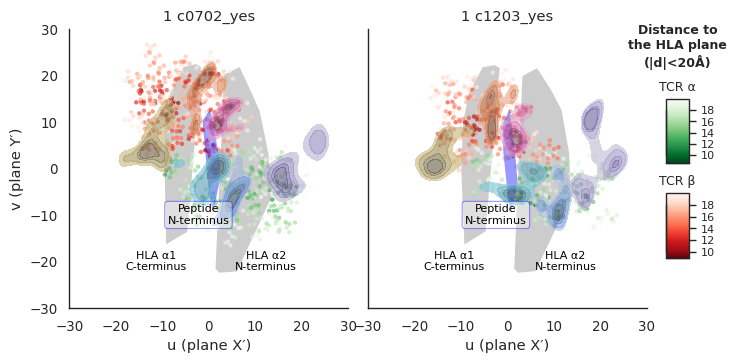

In [89]:
lims = ((-30, 30), (-30, 30))
threshold = 20

shared_norms = make_shared_norms(
    [c0702_yes, c1203_yes],          # put the two dicts you’re comparing here
    z_thresh=threshold,
    color_by="signed"
)

fig, axes = plt.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True, gridspec_kw={"width_ratios": [0.48, 0.48, 0.04], "wspace": 0.1, "hspace": 0.0})

# Redraw each onto the new axes
fig1, ax1, maps1 = plot_atoms_near_plane(
    c0702_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="1 c0702_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(6,4),
    fixed_limits=lims,
    ax=axes[0]
)

fig2, ax2, maps2 = plot_atoms_near_plane(
    c1203_yes,         # dict[str -> np.ndarray (N,3) of (u,v,d)]
    pdbid="1 c1203_yes",
    statistics=None,
    z_thresh=20,
    color_by="signed",          # "abs" or "signed"
    out_png = None,
    share_scale=False,        # share color scale across chains (only for color_by="abs")
    norms_override=shared_norms,
    kde_keys=("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"),
    kde=True,
    kde_levels=(0.6, 0.75, 0.9, 0.95, 1.0),     # contour levels on seaborn's normalized density
    kde_gridsize=200,               # KDE evaluation grid resolution
    kde_bw_adjust=1.0,              # seaborn bw_adjust (>=1.0 smoother KDE)
    kde_legend=False,
    colorbar_legend=False,
    dpi=300,
    figsize=(8,4),
    fixed_limits=lims,
    ax=axes[1]
)

# --- Right panel (colorbars only)
ax_cb = axes[2]
ax_cb.axis("off")  # no data plotted here

divider = make_axes_locatable(ax_cb)

# a small title axes at the very top
cax2 = divider.append_axes("top", size="100%", pad=0.0)
cax1 = divider.append_axes("top", size="100%", pad=0.3)

# Retrieve TRA and TRB mappables from fig2 (killing complexes)
sm_tra = maps2.get("TRA")
sm_trb = maps2.get("TRB")

if sm_trb:
    cbar2 = fig.colorbar(sm_trb, cax=cax2, orientation="vertical")
    cbar2.ax.set_title("TCR β", fontsize=9)
    cbar2.ax.tick_params(labelsize=8)

if sm_tra:
    cbar1 = fig.colorbar(sm_tra, cax=cax1, orientation="vertical")
    cbar1.ax.set_title("TCR α", fontsize=9)
    cbar1.ax.tick_params(labelsize=8)

ax_title = divider.append_axes("top", size="100%", pad=0.2)
ax_title.set_axis_off()
ax_title.text(0.5, 0.5, f"Distance to\nthe HLA plane\n(|d|<{threshold:g}Å)",
              ha="center", va="center", fontsize=9, fontweight="bold")


for a in axes[:2]:
    a.label_outer()
sns.despine(fig=fig, trim=True)
fig.tight_layout(rect=[0, 0, 1, 1])

fig.show()

# pdf_path = os.path.join(base_dir, "side_by_side_with_colorbar_column.pdf")
# fig.savefig(pdf_path, dpi=1000, bbox_inches="tight")
# print(f"[ok] Saved: {pdf_path}")


# Energy distance

In [102]:
from structure.energy_test import energy_test

yes = ['tcr100','tcr102','tcr107','tcr43','tcr76','tcr475','tcr173','tcr371','tcr425','tcr450','tcr452','tcr149','tcr159','tcr363', 'tcr374', 'tcr462','tcr7','tcr168','tcr212','tcr296','tcr177','tcr181','tcr214','tcr20']
no = ['tcr14', 'tcr420', 'tcr520','tcr417']
out = []

for y in yes:
    for n in no:
        print(f"yes {y} - no {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float)[:, :2], 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float)[:, :2], 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'yes',
                'tcr_2': n,
                'tcr_2_kill': 'no',
                'e': stat,
                'p': p,
            })
        
for i, y in enumerate(no):
    if i == len(no)-1:
        continue
    
    for n in no[(i+1):]:
        print(f"no {y} - no {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float)[:, :2], 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float)[:, :2], 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'no',
                'tcr_2': n,
                'tcr_2_kill': 'no',
                'e': stat,
                'p': p,
            })
        
for i, y in enumerate(yes):
    if i == len(yes)-1:
        continue
    
    for n in yes[(i+1):]:
        
        print(f"yes {y} - yes {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float)[:, :2], 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float)[:, :2], 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'yes',
                'tcr_2': n,
                'tcr_2_kill': 'yes',
                'e': stat,
                'p': p,
            })
        

yes tcr100 - no tcr14
yes tcr100 - no tcr420
yes tcr100 - no tcr520
yes tcr100 - no tcr417
yes tcr102 - no tcr14
yes tcr102 - no tcr420
yes tcr102 - no tcr520
yes tcr102 - no tcr417
yes tcr107 - no tcr14
yes tcr107 - no tcr420
yes tcr107 - no tcr520
yes tcr107 - no tcr417
yes tcr43 - no tcr14
yes tcr43 - no tcr420
yes tcr43 - no tcr520
yes tcr43 - no tcr417
yes tcr76 - no tcr14
yes tcr76 - no tcr420
yes tcr76 - no tcr520
yes tcr76 - no tcr417
yes tcr475 - no tcr14
yes tcr475 - no tcr420
yes tcr475 - no tcr520
yes tcr475 - no tcr417
yes tcr173 - no tcr14
yes tcr173 - no tcr420
yes tcr173 - no tcr520
yes tcr173 - no tcr417
yes tcr371 - no tcr14
yes tcr371 - no tcr420
yes tcr371 - no tcr520
yes tcr371 - no tcr417
yes tcr425 - no tcr14
yes tcr425 - no tcr420
yes tcr425 - no tcr520
yes tcr425 - no tcr417
yes tcr450 - no tcr14
yes tcr450 - no tcr420
yes tcr450 - no tcr520
yes tcr450 - no tcr417
yes tcr452 - no tcr14
yes tcr452 - no tcr420
yes tcr452 - no tcr520
yes tcr452 - no tcr417
yes tcr

In [161]:
from structure.energy_test import energy_test

yes = ['tcr363', 'tcr374', 'tcr462','tcr177','tcr181']
no = ['tcr14', 'tcr420', 'tcr520','tcr417']
out = []

for y in yes:
    for n in no:
        print(f"yes {y} - no {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float)[:, :2], 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float)[:, :2], 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'yes',
                'tcr_2': n,
                'tcr_2_kill': 'no',
                'e': stat,
                'p': p,
            })
        
for i, y in enumerate(no):
    if i == len(no)-1:
        continue
    
    for n in no[(i+1):]:
        print(f"no {y} - no {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float), 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float), 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'no',
                'tcr_2': n,
                'tcr_2_kill': 'no',
                'e': stat,
                'p': p,
            })
        
for i, y in enumerate(yes):
    if i == len(yes)-1:
        continue
    
    for n in yes[(i+1):]:
        
        print(f"yes {y} - yes {n}")
        for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
            stat, p = energy_test(
                np.asarray(getattr(tcr_proj[y]['proj_coords'][i], 'coord', tcr_proj[y]['proj_coords'][i]), float), 
                np.asarray(getattr(tcr_proj[n]['proj_coords'][i], 'coord', tcr_proj[n]['proj_coords'][i]),  float), 
                n_perm=2000, seed=42, precompute=True)
            out.append({
                'cdr': i,
                'tcr_1': y,
                'tcr_1_kill': 'yes',
                'tcr_2': n,
                'tcr_2_kill': 'yes',
                'e': stat,
                'p': p,
            })
     
df2 = pd.DataFrame(out)
df2.to_csv(Path(base_dir, "energy_dist_3d.csv"), index=False)

yes tcr363 - no tcr14
yes tcr363 - no tcr420
yes tcr363 - no tcr520
yes tcr363 - no tcr417
yes tcr374 - no tcr14
yes tcr374 - no tcr420
yes tcr374 - no tcr520
yes tcr374 - no tcr417
yes tcr462 - no tcr14
yes tcr462 - no tcr420
yes tcr462 - no tcr520
yes tcr462 - no tcr417
yes tcr177 - no tcr14
yes tcr177 - no tcr420
yes tcr177 - no tcr520
yes tcr177 - no tcr417
yes tcr181 - no tcr14
yes tcr181 - no tcr420
yes tcr181 - no tcr520
yes tcr181 - no tcr417
no tcr14 - no tcr420
no tcr14 - no tcr520
no tcr14 - no tcr417
no tcr420 - no tcr520
no tcr420 - no tcr417
no tcr520 - no tcr417
yes tcr363 - yes tcr374
yes tcr363 - yes tcr462
yes tcr363 - yes tcr177
yes tcr363 - yes tcr181
yes tcr374 - yes tcr462
yes tcr374 - yes tcr177
yes tcr374 - yes tcr181
yes tcr462 - yes tcr177
yes tcr462 - yes tcr181
yes tcr177 - yes tcr181


In [126]:
import pandas as pd
df = pd.DataFrame(out)
df.to_csv(Path(base_dir, "energy_dist.csv"), index=False)

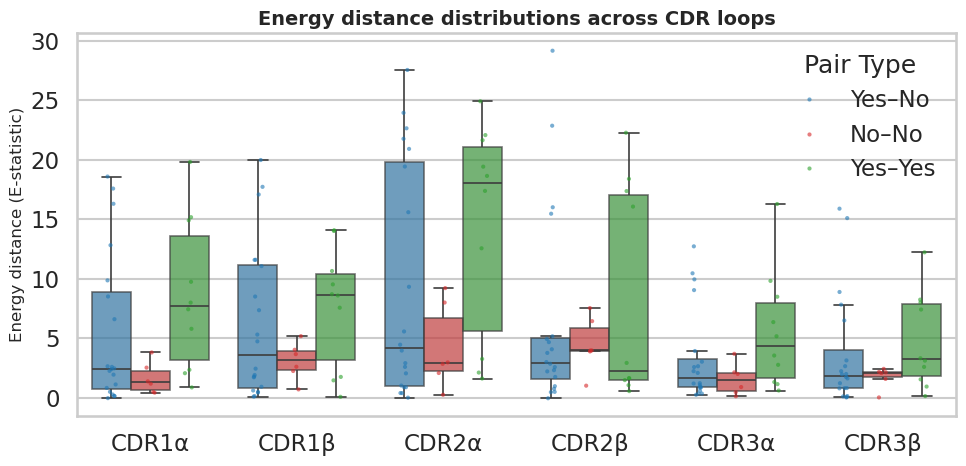

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

edist = df2

# --- derive pair type column ---
def pair_type(row):
    if row["tcr_1_kill"] == "yes" and row["tcr_2_kill"] == "yes":
        return "Yes–Yes"
    elif row["tcr_1_kill"] == "yes" and row["tcr_2_kill"] == "no":
        return "Yes–No"
    elif row["tcr_1_kill"] == "no" and row["tcr_2_kill"] == "no":
        return "No–No"
    else:
        return "Other"

if "pair" not in edist.columns:
    edist["pair"] = edist.apply(pair_type, axis=1)


# --- define plot style ---
sns.set(style="whitegrid", context="talk")

# custom color palette for clarity
palette = {
    "Yes–Yes": "#2ca02c",  # green
    "Yes–No":  "#1f77b4",  # blue
    "No–No":   "#d62728",  # red
}

# --- draw figure ---
plt.figure(figsize=(10,5))
ax = sns.boxplot(
    data=edist[edist["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    palette=palette,
    showcaps=True,
    fliersize=0,
    boxprops=dict(alpha=0.7),
    linewidth=1.2,
)

# --- overlay jittered points ---
sns.stripplot(
    data=edist[edist["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    dodge=True,
    alpha=0.6,
    size=3,
    linewidth=0,
    palette=palette,
    ax=ax
)

# --- fix duplicate legends ---
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Pair Type", frameon=False)

# --- labels and formatting ---
ax.set_xlabel("")
ax.set_ylabel("Energy distance (E-statistic)", fontsize=12)
ax.set_title("Energy distance distributions across CDR loops", fontsize=14, weight="bold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


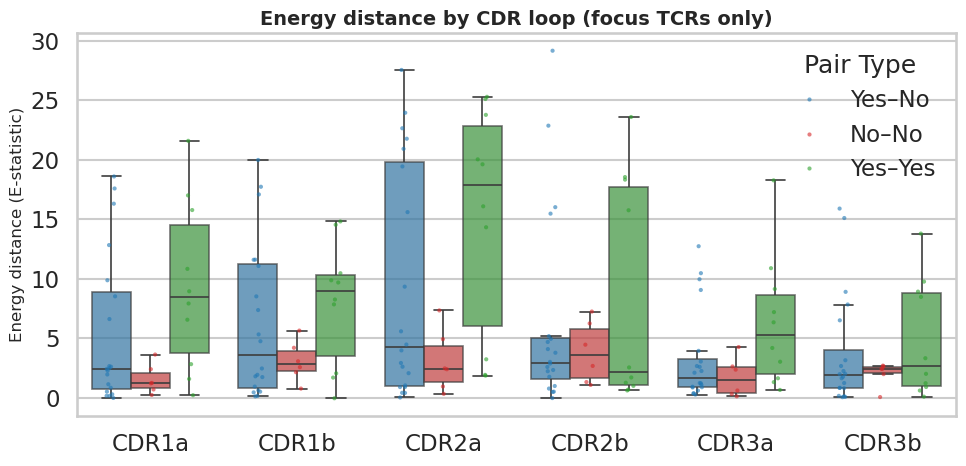

In [154]:
# --- define your TCRs of interest ---
focus_tcrs = ['tcr363','tcr374','tcr462','tcr14','tcr420','tcr520','tcr177','tcr181','tcr417']
# --- filter rows where either TCR matches focus list ---
subset=edist[(edist["tcr_1"].isin(focus_tcrs)) & (edist["tcr_2"].isin(focus_tcrs))]

# --- plotting style ---
sns.set(style="whitegrid", context="talk")

palette = {
    "Yes–Yes": "#2ca02c",  # green
    "Yes–No":  "#1f77b4",  # blue
    "No–No":   "#d62728",  # red
}

plt.figure(figsize=(10,5))
ax = sns.boxplot(
    data=subset[subset["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    palette=palette,
    showcaps=True,
    fliersize=0,
    boxprops=dict(alpha=0.7),
    linewidth=1.2,
)

sns.stripplot(
    data=subset[subset["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    dodge=True,
    alpha=0.6,
    size=3,
    linewidth=0,
    palette=palette,
    ax=ax
)

# --- clean up legend (remove duplicates) ---
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Pair Type", frameon=False)

ax.set_xlabel("")
ax.set_ylabel("Energy distance (E-statistic)", fontsize=12)
ax.set_title("Energy distance by CDR loop (focus TCRs only)", fontsize=14, weight="bold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

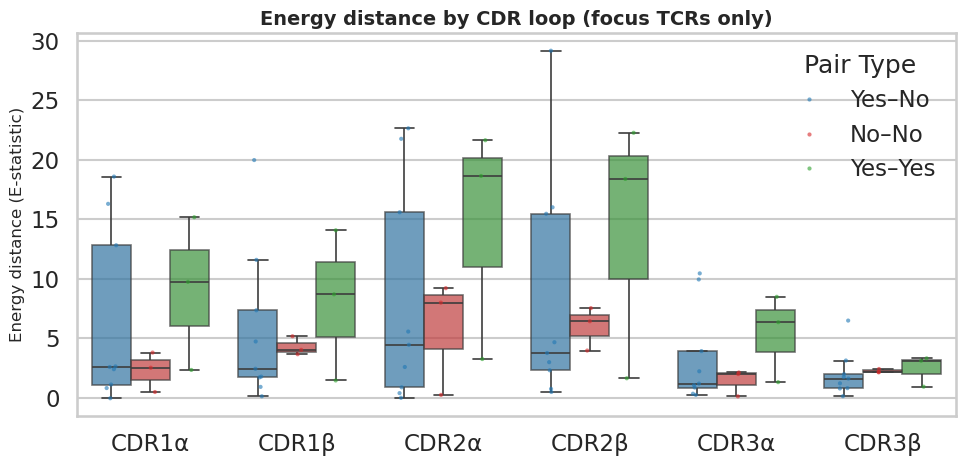

In [163]:
# --- define your TCRs of interest ---
focus_tcrs = ['tcr363','tcr374','tcr462','tcr14','tcr420','tcr520']
# --- filter rows where either TCR matches focus list ---
subset = edist[(edist["tcr_1"].isin(focus_tcrs)) & (edist["tcr_2"].isin(focus_tcrs))]

# --- plotting style ---
sns.set(style="whitegrid", context="talk")

palette = {
    "Yes–Yes": "#2ca02c",  # green
    "Yes–No":  "#1f77b4",  # blue
    "No–No":   "#d62728",  # red
}

plt.figure(figsize=(10,5))
ax = sns.boxplot(
    data=subset[subset["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    palette=palette,
    showcaps=True,
    fliersize=0,
    boxprops=dict(alpha=0.7),
    linewidth=1.2,
)

sns.stripplot(
    data=subset[subset["pair"].isin(["Yes–Yes","Yes–No","No–No"])],
    x="cdr",
    y="e",
    hue="pair",
    dodge=True,
    alpha=0.6,
    size=3,
    linewidth=0,
    palette=palette,
    ax=ax
)

# --- clean up legend (remove duplicates) ---
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Pair Type", frameon=False)

ax.set_xlabel("")
ax.set_ylabel("Energy distance (E-statistic)", fontsize=12)
ax.set_title("Energy distance by CDR loop (focus TCRs only)", fontsize=14, weight="bold")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

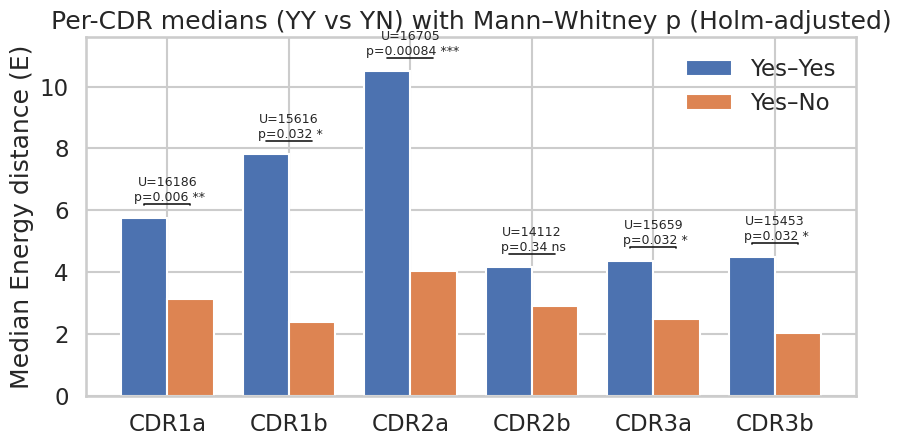

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# # --- define your TCRs of interest ---
# focus_tcrs = ['tcr363','tcr374','tcr462','tcr14','tcr420','tcr520']
# # --- filter rows where either TCR matches focus list ---
# subset = edist[(edist["tcr_1"].isin(focus_tcrs)) & (edist["tcr_2"].isin(focus_tcrs))]

df = edist[edist["pair"].isin(["Yes–Yes","Yes–No"])].copy()
cdr_order = sorted(df["cdr"].unique(), key=str)  # or specify a manual order

# --- compute medians and Mann–Whitney p per CDR ---
rows = []
for c in cdr_order:
    sub = df[df["cdr"]==c]
    yy = sub[sub["pair"]=="Yes–Yes"]["e"].to_numpy()
    yn = sub[sub["pair"]=="Yes–No"]["e"].to_numpy()
    med_yy = np.median(yy) if len(yy) else np.nan
    med_yn = np.median(yn) if len(yn) else np.nan
    if len(yy) and len(yn):
        U, p = mannwhitneyu(yy, yn, alternative="two-sided")
    else:
        U, p = np.nan, np.nan
    rows.append({"cdr": c, "med_yy": med_yy, "med_yn": med_yn, "U": U, "p_raw": p})

stats_df = pd.DataFrame(rows)

# Holm–Bonferroni over CDRs
mask = np.isfinite(stats_df["p_raw"])
adj = np.full(stats_df.shape[0], np.nan, float)
adj[mask] = multipletests(stats_df.loc[mask, "p_raw"].to_numpy(), method="holm")[1]
stats_df["p_holm"] = adj

def p_to_stars(p):
    if not np.isfinite(p): return ""
    return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else
           ("**" if p<0.01 and p>=0.001 else ("***" if p<0.001 and p>=1e-4 else "****")))

stats_df["stars"] = stats_df["p_holm"].apply(p_to_stars)

# --- plotting: grouped bars with bracket + p-value ---
x = np.arange(len(stats_df))
w = 0.38

fig, ax = plt.subplots(figsize=(9,4.8))

b1 = ax.bar(x - w/2, stats_df["med_yy"], width=w, label="Yes–Yes")
b2 = ax.bar(x + w/2, stats_df["med_yn"], width=w, label="Yes–No")

ax.set_xticks(x)
ax.set_xticklabels(stats_df["cdr"])
ax.set_ylabel("Median Energy distance (E)")
ax.set_title("Per-CDR medians (YY vs YN) with Mann–Whitney p (Holm-adjusted)")
ax.legend(frameon=False)

# helper to draw bracket + text
def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2):
    """Draws a bracket from x1 to x2 at height y, with small bump h (in data units)."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=9)

# add brackets per CDR using the two bar tops
ymax = 0.0
for i, (patch1, patch2) in enumerate(zip(b1, b2)):
    h1 = patch1.get_height()
    h2 = patch2.get_height()
    top = max(h1, h2)
    pad = 0.05 * (np.nanmax(stats_df[["med_yy","med_yn"]].to_numpy()) - np.nanmin(stats_df[["med_yy","med_yn"]].to_numpy()) + 1e-9)
    y = top + pad
    x1 = patch1.get_x() + patch1.get_width()/2
    x2 = patch2.get_x() + patch2.get_width()/2
    ptxt = f"U={stats_df.at[i,'U']:.0f}\n p={stats_df.at[i,'p_holm']:.2g} {stats_df.at[i,'stars']}"
    annotate_bracket(ax, x1, x2, y, ptxt)
    ymax = max(ymax, y + pad*1.6)

# give room for annotations
ax.set_ylim(top=ymax)
ax.margins(y=0.15)
plt.tight_layout()
plt.show()


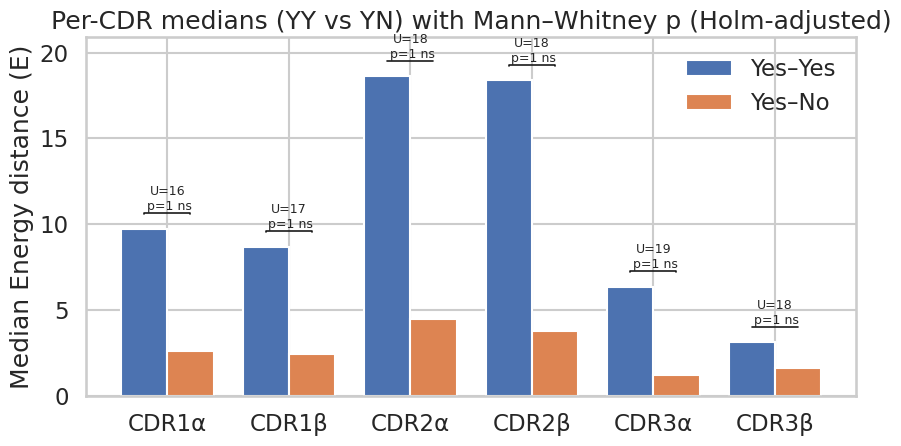

In [164]:
# --- define your TCRs of interest ---
focus_tcrs = ['tcr363','tcr374','tcr462','tcr14','tcr420','tcr520']
# --- filter rows where either TCR matches focus list ---
subset = edist[(edist["tcr_1"].isin(focus_tcrs)) & (edist["tcr_2"].isin(focus_tcrs))]

df = subset[subset["pair"].isin(["Yes–Yes","Yes–No"])].copy()
cdr_order = sorted(df["cdr"].unique(), key=str)  # or specify a manual order

# --- compute medians and Mann–Whitney p per CDR ---
rows = []
for c in cdr_order:
    sub = df[df["cdr"]==c]
    yy = sub[sub["pair"]=="Yes–Yes"]["e"].to_numpy()
    yn = sub[sub["pair"]=="Yes–No"]["e"].to_numpy()
    med_yy = np.median(yy) if len(yy) else np.nan
    med_yn = np.median(yn) if len(yn) else np.nan
    if len(yy) and len(yn):
        U, p = mannwhitneyu(yy, yn, alternative="two-sided")
    else:
        U, p = np.nan, np.nan
    rows.append({"cdr": c, "med_yy": med_yy, "med_yn": med_yn, "U": U, "p_raw": p})

stats_df = pd.DataFrame(rows)

# Holm–Bonferroni over CDRs
mask = np.isfinite(stats_df["p_raw"])
adj = np.full(stats_df.shape[0], np.nan, float)
adj[mask] = multipletests(stats_df.loc[mask, "p_raw"].to_numpy(), method="holm")[1]
stats_df["p_holm"] = adj

def p_to_stars(p):
    if not np.isfinite(p): return ""
    return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else
           ("**" if p<0.01 and p>=0.001 else ("***" if p<0.001 and p>=1e-4 else "****")))

stats_df["stars"] = stats_df["p_holm"].apply(p_to_stars)

# --- plotting: grouped bars with bracket + p-value ---
x = np.arange(len(stats_df))
w = 0.38

fig, ax = plt.subplots(figsize=(9,4.8))

b1 = ax.bar(x - w/2, stats_df["med_yy"], width=w, label="Yes–Yes")
b2 = ax.bar(x + w/2, stats_df["med_yn"], width=w, label="Yes–No")

ax.set_xticks(x)
ax.set_xticklabels(stats_df["cdr"])
ax.set_ylabel("Median Energy distance (E)")
ax.set_title("Per-CDR medians (YY vs YN) with Mann–Whitney p (Holm-adjusted)")
ax.legend(frameon=False)

# helper to draw bracket + text
def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2):
    """Draws a bracket from x1 to x2 at height y, with small bump h (in data units)."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=9)

# add brackets per CDR using the two bar tops
ymax = 0.0
for i, (patch1, patch2) in enumerate(zip(b1, b2)):
    h1 = patch1.get_height()
    h2 = patch2.get_height()
    top = max(h1, h2)
    pad = 0.05 * (np.nanmax(stats_df[["med_yy","med_yn"]].to_numpy()) - np.nanmin(stats_df[["med_yy","med_yn"]].to_numpy()) + 1e-9)
    y = top + pad
    x1 = patch1.get_x() + patch1.get_width()/2
    x2 = patch2.get_x() + patch2.get_width()/2
    ptxt = f"U={stats_df.at[i,'U']:.0f}\n p={stats_df.at[i,'p_holm']:.2g} {stats_df.at[i,'stars']}"
    annotate_bracket(ax, x1, x2, y, ptxt)
    ymax = max(ymax, y + pad*1.6)

# give room for annotations
ax.set_ylim(top=ymax)
ax.margins(y=0.15)
plt.tight_layout()
plt.show()


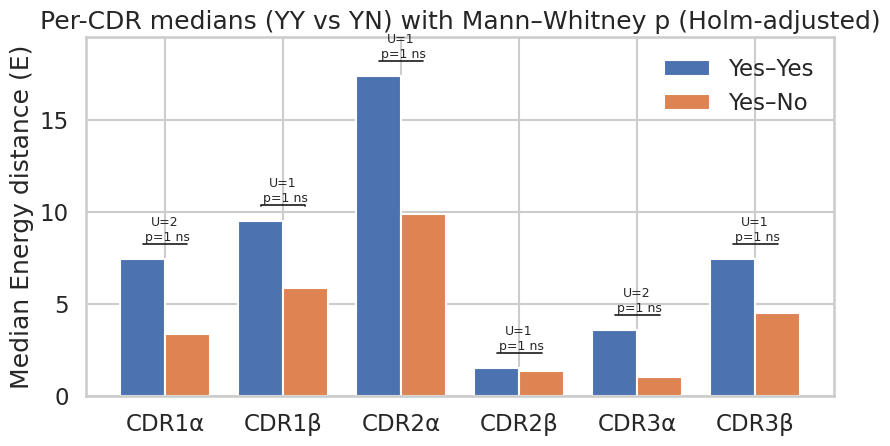

In [165]:
# --- define your TCRs of interest ---
focus_tcrs = ['tcr417','tcr177','tcr181']
# --- filter rows where either TCR matches focus list ---
subset = edist[(edist["tcr_1"].isin(focus_tcrs)) & (edist["tcr_2"].isin(focus_tcrs))]

df = subset[subset["pair"].isin(["Yes–Yes","Yes–No"])].copy()
cdr_order = sorted(df["cdr"].unique(), key=str)  # or specify a manual order

# --- compute medians and Mann–Whitney p per CDR ---
rows = []
for c in cdr_order:
    sub = df[df["cdr"]==c]
    yy = sub[sub["pair"]=="Yes–Yes"]["e"].to_numpy()
    yn = sub[sub["pair"]=="Yes–No"]["e"].to_numpy()
    med_yy = np.median(yy) if len(yy) else np.nan
    med_yn = np.median(yn) if len(yn) else np.nan
    if len(yy) and len(yn):
        U, p = mannwhitneyu(yy, yn, alternative="two-sided")
    else:
        U, p = np.nan, np.nan
    rows.append({"cdr": c, "med_yy": med_yy, "med_yn": med_yn, "U": U, "p_raw": p})

stats_df = pd.DataFrame(rows)

# Holm–Bonferroni over CDRs
mask = np.isfinite(stats_df["p_raw"])
adj = np.full(stats_df.shape[0], np.nan, float)
adj[mask] = multipletests(stats_df.loc[mask, "p_raw"].to_numpy(), method="holm")[1]
stats_df["p_holm"] = adj

def p_to_stars(p):
    if not np.isfinite(p): return ""
    return "ns" if p>=0.05 else ("*" if p<0.05 and p>=0.01 else
           ("**" if p<0.01 and p>=0.001 else ("***" if p<0.001 and p>=1e-4 else "****")))

stats_df["stars"] = stats_df["p_holm"].apply(p_to_stars)

# --- plotting: grouped bars with bracket + p-value ---
x = np.arange(len(stats_df))
w = 0.38

fig, ax = plt.subplots(figsize=(9,4.8))

b1 = ax.bar(x - w/2, stats_df["med_yy"], width=w, label="Yes–Yes")
b2 = ax.bar(x + w/2, stats_df["med_yn"], width=w, label="Yes–No")

ax.set_xticks(x)
ax.set_xticklabels(stats_df["cdr"])
ax.set_ylabel("Median Energy distance (E)")
ax.set_title("Per-CDR medians (YY vs YN) with Mann–Whitney p (Holm-adjusted)")
ax.legend(frameon=False)

# helper to draw bracket + text
def annotate_bracket(ax, x1, x2, y, text, h=0.02, lw=1.2):
    """Draws a bracket from x1 to x2 at height y, with small bump h (in data units)."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="k")
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=9)

# add brackets per CDR using the two bar tops
ymax = 0.0
for i, (patch1, patch2) in enumerate(zip(b1, b2)):
    h1 = patch1.get_height()
    h2 = patch2.get_height()
    top = max(h1, h2)
    pad = 0.05 * (np.nanmax(stats_df[["med_yy","med_yn"]].to_numpy()) - np.nanmin(stats_df[["med_yy","med_yn"]].to_numpy()) + 1e-9)
    y = top + pad
    x1 = patch1.get_x() + patch1.get_width()/2
    x2 = patch2.get_x() + patch2.get_width()/2
    ptxt = f"U={stats_df.at[i,'U']:.0f}\n p={stats_df.at[i,'p_holm']:.2g} {stats_df.at[i,'stars']}"
    annotate_bracket(ax, x1, x2, y, ptxt)
    ymax = max(ymax, y + pad*1.6)

# give room for annotations
ax.set_ylim(top=ymax)
ax.margins(y=0.15)
plt.tight_layout()
plt.show()


In [158]:
agg_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr363', 'tcr374', 'tcr462']})
agg_no = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr14', 'tcr420', 'tcr520']})

for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
    stat, p = energy_test(
        np.asarray(getattr(agg_yes[i], 'coord', agg_yes[i]),  float)[:, :2], 
        np.asarray(getattr(agg_no[i], 'coord', agg_no[i]),  float)[:, :2], 
        n_perm=2000, seed=42, precompute=True)
    print(f"{i}\t\tEnergy distance = {stat:.4f}, p = {p:.6g}")

CDR1α		Energy distance = 1.8789, p = 0.00049975
CDR1β		Energy distance = 1.4582, p = 0.00049975
CDR2α		Energy distance = 2.8659, p = 0.00049975
CDR2β		Energy distance = 1.5740, p = 0.00049975
CDR3α		Energy distance = 0.9807, p = 0.00049975
CDR3β		Energy distance = 0.6703, p = 0.00049975


In [159]:
agg_yes = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr177', 'tcr181']})
agg_no = aggregate_positions({k:v['proj_coords'] for k, v in tcr_proj.items() if k in ['tcr417']})

for i in ("CDR1α","CDR1β","CDR2α","CDR2β","CDR3α","CDR3β"):
    stat, p = energy_test(
        np.asarray(getattr(agg_yes[i], 'coord', agg_yes[i]),  float)[:, :2], 
        np.asarray(getattr(agg_no[i], 'coord', agg_no[i]),  float)[:, :2], 
        n_perm=2000, seed=42, precompute=True)
    print(f"{i}\t\tEnergy distance = {stat:.4f}, p = {p:.6g}")

CDR1α		Energy distance = 1.1659, p = 0.00049975
CDR1β		Energy distance = 3.2078, p = 0.00049975
CDR2α		Energy distance = 5.6023, p = 0.00049975
CDR2β		Energy distance = 1.1716, p = 0.00049975
CDR3α		Energy distance = 0.1925, p = 0.005997
CDR3β		Energy distance = 2.9092, p = 0.00049975


## Find atoms from cytotoxic complexes that was close to the N terminus of the helix

In [23]:
sum(abs(tcr_proj['tcr363']['model'].coord[:,2]) < 10)

2762

In [38]:
for tcr in ['tcr363', 'tcr374', 'tcr462']:
    print(tcr)
    obj = tcr_proj[tcr]['model']
    out = tcr_proj[tcr]['info']
    target = {}
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['tra'], out['cdr_a'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}α"] = sam[~np.isin(sam.atom_name, BACKBONE)]
        
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['trb'], out['cdr_b'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}β"] = sam[~np.isin(sam.atom_name, BACKBONE)]

    for k, v in target.items():
        v = v[v.coord[:,2]<20]
        target[k] = v
        
    for k, v in target.items():
        p, a = struc.get_residues(v)
        res_list = [f"{int(p)}{info.one_letter_code(a)}" for p,a in zip(p,a)]
        print(f"{k}: {', '.join(res_list)}")
    print("\n")

tcr363
CDR1α: 25Y, 26T, 27N, 29Y, 30S, 31P, 32A, 40Y
CDR2α: 66E, 67N
CDR3α: 109D, 110L, 111G, 112G, 113G, 114T, 132D, 133S, 134W, 135G, 136K, 138Q
CDR1β: 32E, 40Y, 41M
CDR2β: 58S, 59V, 60G, 66A, 67G, 68I, 69T, 70D, 71Q, 72G, 73E, 74V, 75P, 76N, 77G
CDR3β: 110Y, 111S, 112P, 113G, 133R, 134I, 135Y


tcr374
CDR1α: 29R, 30D, 31T, 32T, 39Y, 40Y
CDR2α: 59N, 60S, 66F, 67D, 68E
CDR3α: 110E, 111A, 112L, 113L, 114A, 132G, 133G, 134S, 135E
CDR1β: 25Q, 29M, 30N, 31H, 32E, 40Y, 41M
CDR2β: 58S, 59M, 60N, 66V, 67E, 68V, 69T, 70D
CDR3β: 109K, 110A, 111G, 112G, 135Y


tcr462
CDR1α: 30A, 31L, 32Y, 40S, 41V, 42H
CDR2α: 58L, 59L, 66K, 67G, 68G, 69E, 70Q, 71K
CDR3α: 109V, 110L, 111F, 112T, 134G, 135N, 136Q
CDR1β: 25Q, 26D, 29M, 30N, 31H, 32E, 40Y, 41M
CDR2β: 58S, 59V, 60G, 66A, 67G, 68I, 69T, 70D
CDR3β: 109S, 110Y, 111G, 112Q, 134N, 135Y, 136G




In [39]:
for tcr in ['tcr14', 'tcr420', 'tcr520']:
    print(tcr)
    obj = tcr_proj[tcr]['model']
    out = tcr_proj[tcr]['info']
    target = {}
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['tra'], out['cdr_a'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}α"] = sam[~np.isin(sam.atom_name, BACKBONE)]
        
    for cdr in ['cdr1','cdr2','cdr3']:
        start, end = get_subsequence_indices(obj, out['chain_id']['trb'], out['cdr_b'][cdr])
        sam = obj[start:end]
        target[f"{cdr.upper()}β"] = sam[~np.isin(sam.atom_name, BACKBONE)]

    for k, v in target.items():
        v = v[v.coord[:,2]<20]
        target[k] = v
        
    for k, v in target.items():
        p, a = struc.get_residues(v)
        res_list = [f"{int(p)}{info.one_letter_code(a)}" for p,a in zip(p,a)]
        print(f"{k}: {', '.join(res_list)}")
    print("\n")

tcr14
CDR1α: 29R, 30D, 31T, 32T, 39Y, 40Y, 42F
CDR2α: 59N, 60S, 66F, 67D, 68E
CDR3α: 109S, 110E, 111D, 112Q, 135N, 136Q
CDR1β: 25P, 26I, 29S, 30G, 31H, 32T, 40A, 41L, 42Y
CDR2β: 58F, 59Q, 60G, 65T, 66G, 67A, 68A, 69D, 70D, 71S, 73L
CDR3β: 108S, 109S, 110P, 111I, 112G, 113S, 133P, 134T, 135D, 136T, 138Y


tcr420
CDR1α: 29R, 30D, 31T, 32T, 39Y, 40Y
CDR2α: 59N, 60S, 66F, 67D, 68E, 69Q
CDR3α: 109S, 110E, 111E, 112N, 134F, 135N, 136K
CDR1β: 25Q, 29M, 30N, 31H, 32N, 40S, 41M, 42Y
CDR2β: 58S, 59A, 60S, 66E, 67G, 68T, 69T, 70D, 71K
CDR3β: 109S, 110R, 111F, 112G, 134Q, 135E


tcr520
CDR1α: 29I, 30A, 31T, 32N, 39D, 40Y, 41I
CDR2α: 58G, 67Y, 68K, 69T, 70K, 71V, 72T, 75N, 76E
CDR3α: 108V, 109G, 110D, 111S, 112L, 113G, 114G, 133G, 135Y
CDR1β: 26I, 29S, 30G, 31H, 32V, 40S, 42Y
CDR2β: 59N, 60Y, 65E, 66A, 68Q
CDR3β: 109S, 110P, 111R, 112Q, 113D, 134S, 135Y, 136E, 138Y


